# Laptop Price Prediction — Model Training
In this notebook, we will train and evaluate two Linear Regression models to predict laptop prices.
- Model A: Linear Regression with all available features.
- Model B: Linear Regression with selected features only.

We will:
- Load the cleaned dataset.
- Split into train/test sets.
- Optionally scale numeric features.
- Train the two baseline Linear Regression models.
- Evaluate with MAE, RMSE and R².
- Visualize predictions and save the best model (for later Streamlit use).

### Step 0 - Imports
Import necessary libraries (Imports used throughout the notebook).

In [18]:
# Step 0 - imports
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
# We will use random_state=1 and test_size=0.2 (20%) as our group's values.
RANDOM_STATE = 1
TEST_SIZE = 0.2  # This is actually 20%.

# Ensure output folders exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/figures", exist_ok=True)

### Step 1 - Load Dataset
Load the processed CSV saved from data cleaning.

In [19]:
data = pd.read_csv("../data/processed/laptops_clean.csv")
print("Shape:", data.shape)
display(data.head())
print("\nMissing values per column:\n", data.isnull().sum())

Shape: (1303, 26)


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Price_euros,SSD,HDD,Hybrid,Flash_Storage,Touchscreen,X_res,Y_res,Cpu_brand,Gpu_brand
0,0,0,0,0,0,1,0,0,0,0,...,1339.69,128,0,0,0,0,2560,1600,Intel,Intel
1,0,0,0,0,1,0,0,0,0,0,...,898.94,0,0,0,128,0,1440,900,Intel,Intel
2,0,0,0,0,0,0,0,1,0,0,...,575.00,256,0,0,0,0,1920,1080,Intel,Intel
3,0,0,0,0,0,1,0,0,0,0,...,2537.45,512,0,0,0,0,2880,1800,Intel,AMD
4,0,0,0,0,0,1,0,0,0,0,...,1803.60,256,0,0,0,0,2560,1600,Intel,Intel



Missing values per column:
 col_0            0
col_1            0
col_2            0
col_3            0
col_4            0
col_5            0
col_6            0
col_7            0
col_8            0
col_9            0
Company          0
TypeName         0
Inches           0
Ram              0
OpSys            0
Weight           0
Price_euros      0
SSD              0
HDD              0
Hybrid           0
Flash_Storage    0
Touchscreen      0
X_res            0
Y_res            0
Cpu_brand        0
Gpu_brand        0
dtype: int64


### Step 2 - Definition
- Encode categorical features before training. (Linear Regression cannot handle string columns like "Dell", "Windows 10", etc.)
- We replace categorical features with the mean price of laptops in each category. For example, all Dell laptops are replaced by the average price of Dell laptops. This reduces dimensionality (compared to one-hot encoding).
- Define features (X) and target (y).
- Separate predictors and target variable.

In [20]:
if "Price_euros" not in data.columns:
    raise KeyError("Target column 'Price_euros' not found in dataset.")

# Detect categorical columns
categorical_columns = ['Company', 'TypeName', 'OpSys', 'Cpu_brand', 'Gpu_brand']
print("Categorical columns:", categorical_columns)

for column in categorical_columns:
    data[column] = data[column].astype(str).str.strip()  # Clean whitespaces
    mean_encoding = data.groupby(column)['Price_euros'].mean()
    global_mean = data['Price_euros'].mean()
    data[column] = data[column].map(mean_encoding).fillna(global_mean)

# print("Shape after target encoding:", data.shape)

X = data.drop("Price_euros", axis=1)
y = data["Price_euros"]

print("X shape:", X.shape)
print("y shape:", y.shape)

Categorical columns: ['Company', 'TypeName', 'OpSys', 'Cpu_brand', 'Gpu_brand']
X shape: (1303, 25)
y shape: (1303,)


### Step 3 — Train / Test Split
- Reserve 20% for test. 
- Keep random_state for reproducibility.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)
print("X_train:", X_train.shape,
      "X_test:", X_test.shape)

X_train: (1042, 25) X_test: (261, 25)


### Step 4 — Baseline model: Linear Regression
- Train a linear regression on the scaled features.
- We scale the numeric features so they're on the same range, which helps linear regression models perform better.

In [22]:
# Detect numeric columns (should already be numeric after cleaning)
numeric_columns = X_train.select_dtypes(include=np.number).columns.tolist()
print("numeric columns:", numeric_columns)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale numeric columns for linear regression
scaler = StandardScaler()

# Fit scaler only on training numeric columns
X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])

# print("Shape after scaling:", X_train_scaled.shape, X_test_scaled.shape)

# Save scaler for later (inference)
joblib.dump(scaler, "../models/scaler.pkl")
print("Scaler saved to ../models/scaler.pkl")

non_numeric = X_train.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns:", non_numeric.tolist())

numeric columns: ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'SSD', 'HDD', 'Hybrid', 'Flash_Storage', 'Touchscreen', 'X_res', 'Y_res', 'Cpu_brand', 'Gpu_brand']
Scaler saved to ../models/scaler.pkl

Non-numeric columns: []


### Step 5 - Train First Model (A)
- This model will be trained on all features to see it's accuracy gap when compared with model B.

In [23]:
# Train Linear Regression (on scaled data)
linear_reg_A = LinearRegression()
linear_reg_A.fit(X_train_scaled, y_train)

y_pred_A = linear_reg_A.predict(X_test_scaled)

### Step 6 — Evaluate First Model (A)
- Print MAE, RMSE and R² for Model A.

In [24]:
# Evaluate linear regression for A.
mae_A = mean_absolute_error(y_test, y_pred_A).__round__(4)
rmse_A = np.sqrt(mean_squared_error(y_test, y_pred_A)).__round__(4)   # <- replace squared=False with np.sqrt(...)
r2_A = r2_score(y_test, y_pred_A).__round__(4)

print("Linear Regression A Performance:")
print(f"MAE: {mae_A}")
print(f"RMSE: {rmse_A}")
print(f"R²: {r2_A}")

Linear Regression A Performance:
MAE: 236.2049
RMSE: 321.3514
R²: 0.79


### Step 7 — Train Second Model (B)
- Train the model with reduced features.
- We can drop Flash_Storage and Hybrid since they don't usually appear often.

In [25]:
# Train Random Forest (using unscaled data).
X_reduced = data.drop(["Price_euros", "Flash_Storage", "Hybrid"], axis=1)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_reduced, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train_b_scaled = scaler.fit_transform(X_train_b)
X_test_b_scaled = scaler.fit_transform(X_test_b)

linear_reg_B = LinearRegression()
linear_reg_B.fit(X_train_b_scaled, y_train_b)

y_pred_B = linear_reg_B.predict(X_test_b_scaled)

### Step 8 — Evaluate Second Model (B)
- Compare metrics with first linear regression model.

In [26]:
# Evaluate Linear Regression for B.
mae_B = mean_absolute_error(y_test, y_pred_B).__round__(4)
rmse_B = np.sqrt(mean_squared_error(y_test, y_pred_B)).__round__(4)
r2_B = r2_score(y_test, y_pred_B).__round__(4)

print("Linear Regression B Performance:")
print(f"MAE: {mae_B}")
print(f"RMSE: {rmse_B}")
print(f"R²: {r2_B}")

Linear Regression B Performance:
MAE: 240.4856
RMSE: 325.8529
R²: 0.7841


### Step 9: Compare Models
- Collect metrics into a DataFrame for easy comparison.

In [27]:
results = pd.DataFrame({
    "model": ["Linear Regression (All Features)", "Linear Regression (Reduced Features)"],
    "MAE": [mae_A, mae_B],
    "RMSE": [rmse_A, rmse_B],
    "R²": [r2_A, r2_B]
})
display(results.sort_values("R²", ascending=False))
# Save metrics
results.to_csv("../reports/model_results_summary.csv", index=False)
print("Saved metrics to ../reports/model_results_summary.csv")

,model,MAE,RMSE,R²
0,Linear Regression (All Features),236.2049,321.3514,0.7900
1,Linear Regression (Reduced Features),240.4856,325.8529,0.7841


Saved metrics to ../reports/model_results_summary.csv


### Step 10 — Visualize predictions vs actual (best model)
- Plot actual vs predicted and a 45° line to see fit.

In [28]:
# Step 11 - Choose best model and visualize
best_model = linear_reg_A if r2_A >= r2_B else linear_reg_B
if best_model == linear_reg_A:
    final_model = "Linear Model A"
elif best_model == linear_reg_B:
    final_model = "Linear Model B"
else:
    print("")
best_pred = y_pred_A if best_model is linear_reg_A else y_pred_B
print("Best Model:", final_model)


Best Model: Linear Model A


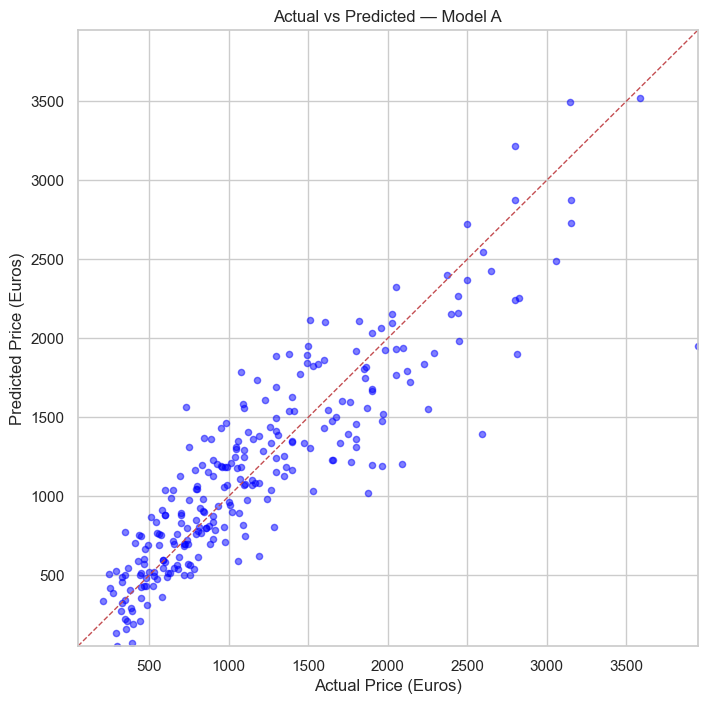

Plot saved to ../reports/figures/actual_vs_predicted_model_A.png


In [29]:
# For Model A
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_A, alpha=0.5, s=20, color="blue")
lims = [min(y_test.min(), y_pred_A.min()), max(y_test.max(), y_pred_A.max())]
plt.plot(lims, lims, 'r--', linewidth=1)  # identity line
plt.xlabel("Actual Price (Euros)")
plt.ylabel("Predicted Price (Euros)")
plt.title("Actual vs Predicted — Model A")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.savefig("../reports/figures/actual_vs_predicted_model_A.png", dpi=150)
plt.show()
print("Plot saved to ../reports/figures/actual_vs_predicted_model_A.png")

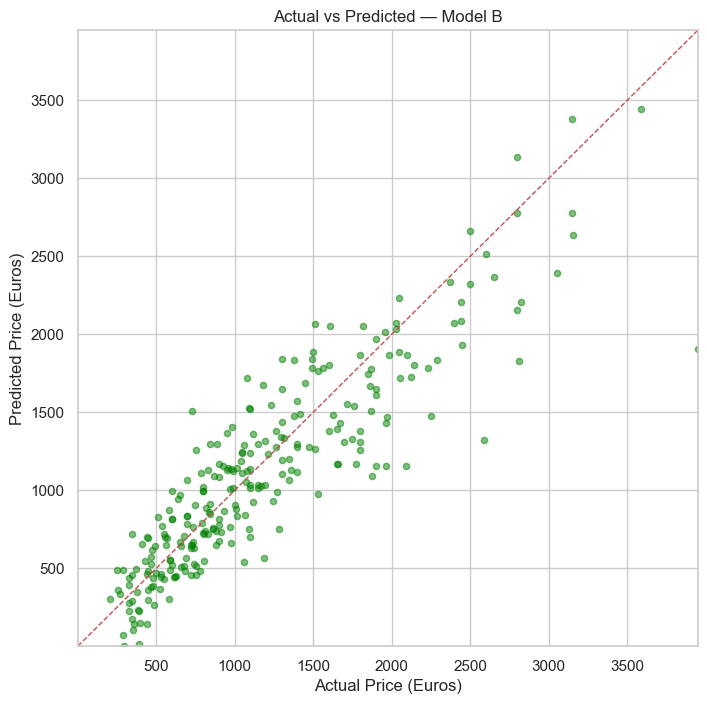

Plot saved to ../reports/figures/actual_vs_predicted_model_B.png


In [30]:
# For Model B
plt.figure(figsize=(8,8))
plt.scatter(y_test_b, y_pred_B, alpha=0.5, s=20, color="green")
lims = [min(y_test_b.min(), y_pred_B.min()), max(y_test_b.max(), y_pred_B.max())]
plt.plot(lims, lims, 'r--', linewidth=1)  # identity line
plt.xlabel("Actual Price (Euros)")
plt.ylabel("Predicted Price (Euros)")
plt.title("Actual vs Predicted — Model B")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.savefig("../reports/figures/actual_vs_predicted_model_B.png", dpi=150)
plt.show()
print("Plot saved to ../reports/figures/actual_vs_predicted_model_B.png")

### Step 11 — Save the best model for deployment
- Simply save the model file to `../models` for use in Streamlit or inference.

In [31]:
best_model_path = "../models/best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Saved best model to {best_model_path}")
# If you trained linear regression and plan to use the scaler, scaler already saved earlier.

Saved best model to ../models/best_model.pkl


### Step 12 - Feature Importance (Linear Regression Coefficients)
We check the model's coefficients to see which features (RAM, CPU brand, GPU brand, etc.) have the most influence on laptop prices. Positive coefficients mean the feature increases price, negative coefficients mean it reduces price.

Top 10 most influential factors:
      Feature  Coefficient  Abs_Coefficient
13        Ram   239.604742       239.604742
11   TypeName   159.240501       159.240501
16        SSD   157.816909       157.816909
22      Y_res    99.764133        99.764133
14      OpSys    95.655566        95.655566
10    Company    87.397924        87.397924
15     Weight    82.008973        82.008973
12     Inches   -50.975661        50.975661
23  Cpu_brand    47.893317        47.893317
1       col_1    33.073920        33.073920


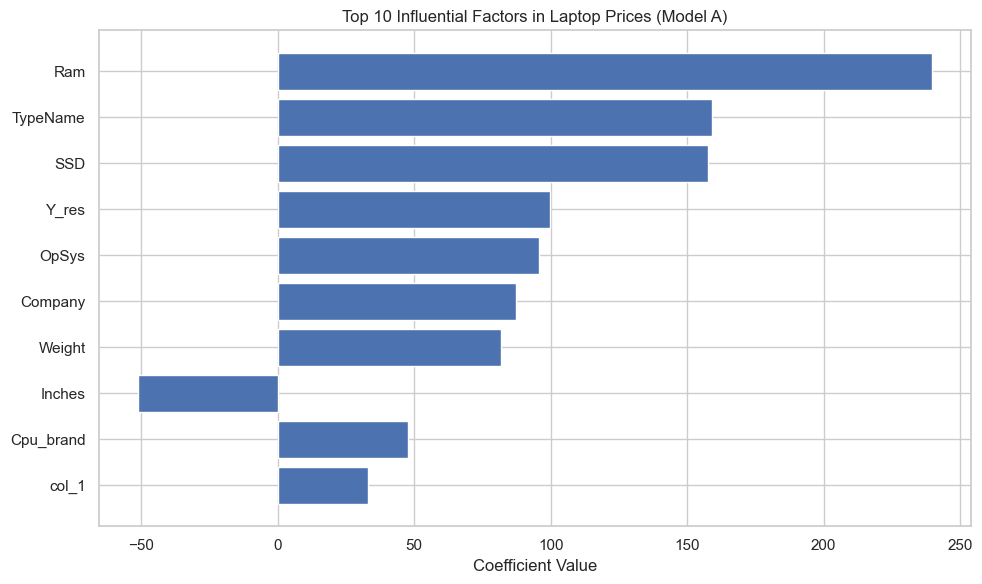

In [32]:
# Get feature importance from Model A (assuming linear_reg is Model A)
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": linear_reg_A.coef_
})

# Sort by absolute value of coefficient (most influential first)
feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)

print("Top 10 most influential factors:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(10,6))
plt.barh(feature_importance["Feature"][:10], feature_importance["Coefficient"][:10])
plt.xlabel("Coefficient Value")
plt.title("Top 10 Influential Factors in Laptop Prices (Model A)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [33]:
# Save CSV
feature_importance.to_csv("../reports/linear_regression_feature_importance.csv", index=False)
print("Feature importance saved to '../reports/linear_regression_feature_importance.csv'.")

# Save Visualization
plt.savefig("../reports/figures/linear_regression_feature_importance.png", dpi=300)
print("Bar chart saved to '../reports/figures/linear_regression_feature_importance.png'.")

Feature importance saved to '../reports/linear_regression_feature_importance.csv'.
Bar chart saved to '../reports/figures/linear_regression_feature_importance.png'.


<Figure size 640x480 with 0 Axes>

### Step 13 — Next steps (notes)
- If deployment is required, create a small API or Streamlit app that loads the model and the scaler.
- Save feature list and preprocessing steps (so you apply exactly the same transforms at inference).

In [34]:
# Step 13 - Save feature list
feature_list_path = "../models/feature_names.pkl"
cat_cols = X_train.select_dtypes(include=['object'])
joblib.dump(cat_cols.columns.tolist(), feature_list_path)
print(f"Saved feature names to {feature_list_path}")

Saved feature names to ../models/feature_names.pkl
